# Vasicek Model with Benchmarking Against Treasury Data

### Overview
This Python script is inspired by the Kaggle project Vasicek Model: Predicting Interest Rates (https://www.kaggle.com/code/subhanjan33/vasicek-model-predicting-interest-rates/notebook), which demonstrates the use of the Vasicek short-rate model for forecasting interest rates using historical data.

### What’s New in This Version

In addition to replicating the original modeling approach, this version introduces a benchmarking layer:

- Forecasted interest rates from the Vasicek model are compared against recent market data.
- Benchmark data is sourced from the 3-Month Treasury Bill rate available via FRED (https://fred.stlouisfed.org/series/TB3MS).
This enhancement allows for a more realistic evaluation of the model’s predictive performance against actual market conditions.

https://www.kaggle.com/code/subhanjan33/vasicek-model-predicting-interest-rates/notebook

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from scipy.optimize import minimize

import warnings, gc
warnings.filterwarnings("ignore")

# 📈 Vasicek Interest Rate Modeling and Forecasting

This project implements the Vasicek short-rate model to forecast interest rates using historical data and benchmarks the results against real-world market data from the 3-Month Treasury Bill.

---

## 🔧 Approach Summary

### 1. **Data Preprocessing**
- Load historical interest rate data from a CSV file.
- Convert dates to datetime format and clean missing or non-numeric entries.
- Normalize interest rates by converting percentages to decimals.
- Set the date as the index for time series analysis.

### 2. **Parameter Estimation via Maximum Likelihood**
- Define the Vasicek model:
  \[
  dr_t = \alpha(\beta - r_t)dt + \sigma dW_t
  \]
- Construct a log-likelihood function based on the model's transition density.
- Use `scipy.optimize.minimize` to estimate parameters \( \alpha, \beta, \sigma \) under positivity constraints.

### 3. **Simulation of Future Interest Rates**
- Simulate multiple future paths of interest rates using the calibrated Vasicek model.
- Use a time step of 1/252 to represent daily business days.
- Generate 3 years of simulated data (approximately 756 business days).

### 4. **Visualization**
- Plot historical interest rates alongside the mean of simulated future rates.
- Visualize multiple simulation paths to illustrate uncertainty and variability.

### 5. **Benchmarking**
- Compare the simulated forecast with actual market data from the FRED 3-Month Treasury Bill (TB3MS).
- This benchmarking step helps validate the model's predictive performance.

### 6. **Exporting Forecast**
- Save the mean of the simulated interest rate forecasts to a CSV file:
  - `vasicek_simulated_forecast.csv`

---



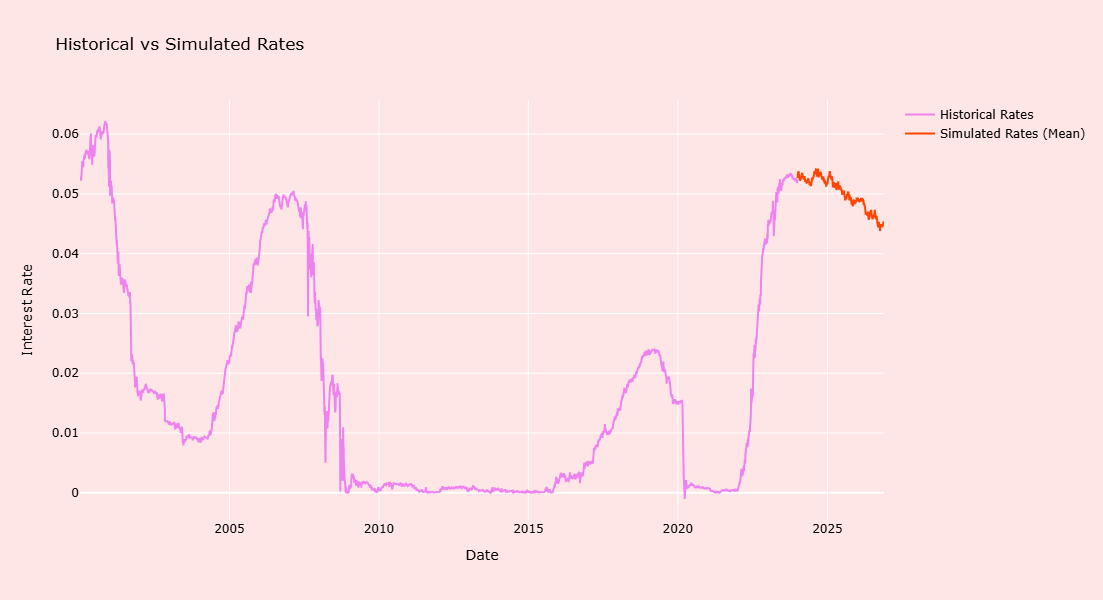

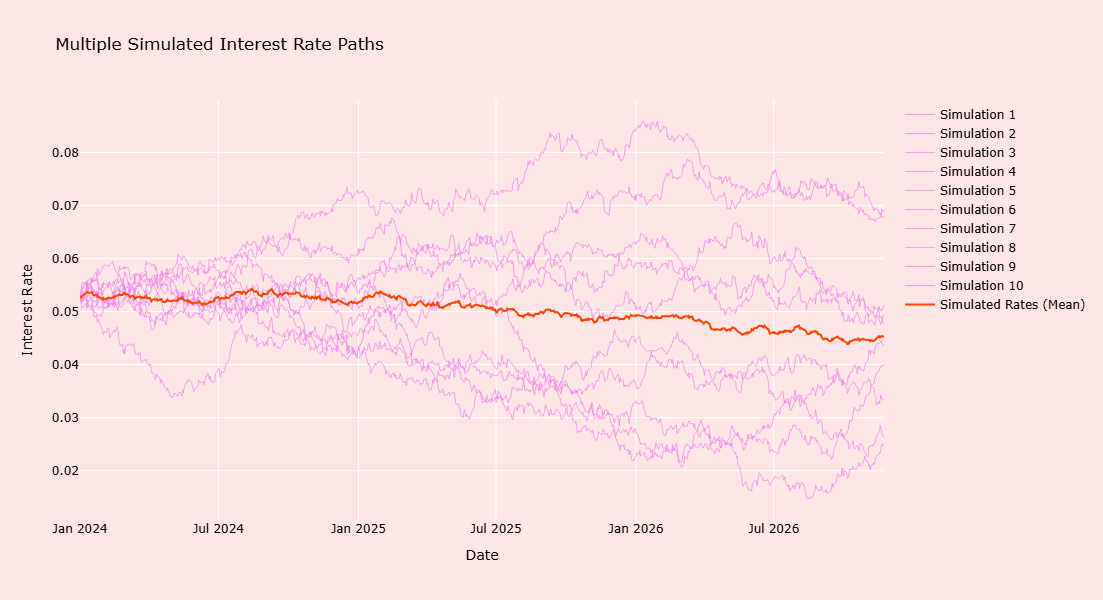

In [10]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from scipy.optimize import minimize

# Load and clean the data
data1 = pd.read_csv("3m_treasury_bill_interest_rates.csv")
df = data1[['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
df = df.dropna()
df['Adj Close'] = df['Adj Close'] / 100
df.set_index('Date', inplace=True)

# Initial interest rate
r0 = df['Adj Close'].iloc[0]

# Vasicek log-likelihood function
def vasicek_log_likelihood(params, data):
    alpha, beta, sigma = params
    dt = 1 / 252
    log_likelihood = 0
    for t in range(1, len(data)):
        r_t = data[t - 1]
        r_t1 = data[t]
        expected_r_t1 = r_t + alpha * (beta - r_t) * dt
        var_r_t1 = sigma**2 * dt
        log_likelihood += -0.5 * ((r_t1 - expected_r_t1)**2 / var_r_t1 + np.log(2 * np.pi * var_r_t1))
    return -log_likelihood

# Optimize parameters
data = df['Adj Close'].values.astype(float)
initial_params = [0.1, 0.02, 0.01]
bounds = [(0, None), (0, None), (0, None)]
result = minimize(vasicek_log_likelihood, initial_params, args=(data,), method='L-BFGS-B', bounds=bounds)
alpha_opt, beta_opt, sigma_opt = result.x

# Simulation function
def vasicek_simulation_opt(r0, alpha, beta, sigma, num_days, num_simulations):
    dt = 1 / 252
    rates = np.zeros((num_days, num_simulations))
    rates[0] = r0
    for t in range(1, num_days):
        rates[t] = rates[t-1] + alpha * (beta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(size=num_simulations)
    return rates

# Simulate future rates
num_simulations = 10
num_days = 252 * 3
start_date = df.index[-1] + pd.Timedelta(days=1)
dates = pd.date_range(start=start_date, periods=num_days, freq='B')
simulated_rates_opt = vasicek_simulation_opt(r0, alpha_opt, beta_opt, sigma_opt, num_days, num_simulations)
simulated_df_opt = pd.DataFrame(simulated_rates_opt, index=dates)

# Plotting
background_color = "#ffe6e6"
color_palette = ['violet', 'orangered']

# Historical vs Mean Simulated
trace1 = go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', name='Historical Rates', line=dict(color='violet', width=2))
trace2 = go.Scatter(x=simulated_df_opt.index, y=simulated_df_opt.mean(axis=1), mode='lines', name='Simulated Rates (Mean)', line=dict(color='orangered', width=2))
layout1 = go.Layout(title='Historical vs Simulated Rates', xaxis=dict(title='Date'), yaxis=dict(title='Interest Rate'), plot_bgcolor=background_color, paper_bgcolor=background_color, font=dict(color="black"), height=600, width=900)
fig1 = go.Figure(data=[trace1, trace2], layout=layout1)
pio.show(fig1)

# Multiple Simulations
simulation_traces_opt = [go.Scatter(x=simulated_df_opt.index, y=simulated_df_opt.iloc[:, i], mode='lines', name=f'Simulation {i+1}', line=dict(color='violet', width=1), opacity=0.7) for i in range(num_simulations)]
trace_mean = go.Scatter(x=simulated_df_opt.index, y=simulated_df_opt.mean(axis=1), mode='lines', name='Simulated Rates (Mean)', line=dict(color='orangered', width=2))
layout2 = go.Layout(title='Multiple Simulated Interest Rate Paths', xaxis=dict(title='Date'), yaxis=dict(title='Interest Rate'), plot_bgcolor=background_color, paper_bgcolor=background_color, font=dict(color="black"), height=600, width=900)
fig2 = go.Figure(data=simulation_traces_opt + [trace_mean], layout=layout2)
pio.show(fig2)


# Duration of simulation

In [ ]:
import pandas as pd

# Number of simulated business days
num_days = 252 * 3  # 3 years of trading days

# Determine the start date for simulation
start_date = df.index[-1] + pd.Timedelta(days=1)

# Generate the date range for simulation
dates = pd.date_range(start=start_date, periods=num_days, freq='B')

# Determine the end date for simulation
end_date = dates[-1]

print(f"The simulated interest rate prediction period starts from {start_date.date()} to {end_date.date()}.")


# Saving the forecasted data

In [ ]:
# Extract the mean of the simulated rates
simulated_mean_rates = simulated_df_opt.mean(axis=1)

# Create a DataFrame with the dates and mean simulated rates
forecasted_data = pd.DataFrame({
    'Date': simulated_mean_rates.index,
    'Simulated Rate (Mean)': simulated_mean_rates.values
})

# Save the DataFrame to a CSV file
forecasted_data.to_csv('vasicek_simulated_forecast.csv', index=False)
print("Forecast saved to 'vasicek_simulated_forecast.csv'")


In [ ]:
data_f = pd.read_csv('vasicek_simulated_forecast.csv')
data_f.head()

# Benchmarking with 3-Month Treasury Bill 

https://fred.stlouisfed.org/series/TB3MS

In [ ]:
data_b = pd.read_csv('TB3MS.csv')
data_b.head()

In [ ]:
# Convert 'observation_date' to datetime
data_b['Date'] = pd.to_datetime(data_b['observation_date'])

# Filter the data between 2023-12-30 and 2026-05-25
filtered_data_b = data_b[(data_b['Date'] >= '2023-12-30') & (data_b['Date'] <= '2026-05-25')]

# Display the first few rows
print(filtered_data_b.head())


In [ ]:
# Rename TB3MS to Interest rate
filtered_data_b.rename(columns={'TB3MS': 'Rate'}, inplace=True)

# Drop 'observation_date' and reset index
#filtered_data_b = filtered_data_b.drop(columns=['observation_date']).reset_index(drop=True)

# Scale the 'TB3MS'or 'Rate' column
filtered_data_b['Rate'] = filtered_data_b['Rate'] / 100

# Display the result
print(filtered_data_b.head())




In [ ]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio

# Ensure 'Date' columns are datetime
data_f['Date'] = pd.to_datetime(data_f['Date'])
filtered_data_b['Date'] = pd.to_datetime(filtered_data_b['Date'])

# Plotting
trace1 = go.Scatter(
    x=filtered_data_b['Date'], y=filtered_data_b['Rate'],
    mode='lines', name='Historical Rates',
    line=dict(color='blue', width=2)
)

trace2 = go.Scatter(
    x=data_f['Date'], y=data_f['Simulated Rate (Mean)'],
    mode='lines', name='Simulated Rates (Mean)',
    line=dict(color='red', width=2)
)

layout = go.Layout(
    title='Benchmarked forecasted rates across 3-Month Treasury Bill Secondary Market Rate',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Interest Rate'),
    plot_bgcolor="#ffe6e6",
    paper_bgcolor="#ffe6e6",
    font=dict(color="black"),
    height=600,
    width=900
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
pio.show(fig)
